# Sélection des bandes discriminantes pour les images hyperspectrales
# Méthode : coefficient de déflexion VS ES coefficient de déflexion

**Ce notebook implémente une approche de classification multiclasse basée sur le coefficient de déflexion pour la sélection de bandes spectrales. Nous calculons le coefficient de déflexion DC = (μi - μj)²/(σi · σj) pour chaque paire de classes sur toutes les bandes, puis utilisons le critère "worst-case" en sélectionnant pour chaque bande la valeur minimale du coefficient de déflexion parmi toutes les paires de classes. Deux stratégies sont évaluées : la première sélectionne directement les meilleures bandes selon leur coefficient de déflexion global (top 5, 10, 15, 20), tandis que la seconde applique une approche de segmentation spectrale en divisant l'espace spectral en segments égaux et en choisissant la meilleure bande de chaque segment selon ce critère. Les modèles MLP résultants sont comparés pour déterminer l'efficacité du coefficient de déflexion comme métrique de sélection de bandes pour la classification hyperspectrale multiclasse.**

### Dataset : Indian Pines 

In [16]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [17]:
# Définir le chemin du dataset
dataset_path = "/kaggle/input/dataset-deflection-coefficient"  # Chemin vers le dossier du dataset

###   Étape 1: Charger les données hyperspectrales et les vérités terrain

In [18]:
def charger_donnees(dataset_path):
    """
    Charge les images hyperspectrales et les vérités terrain.
    
    Args:
        dataset_path: Chemin vers le dossier contenant les fichiers .mat
    
    Returns:
        donnees_hyperspectrales: Données spectrales (n_rows, n_cols, n_bands)
        verite_terrain: Vérités terrain (n_rows, n_cols)
    """
    print("\n" + "="*80)
    print("ÉTAPE 1: CHARGEMENT DES DONNÉES HYPERSPECTRALES")
    print("="*80)
    
    # Chargement des données corrigées
    chemin_image = os.path.join(dataset_path, "Indian_pines_corrected.mat")
    donnees_mat = loadmat(chemin_image)
    
    # Utiliser le nom de variable exact pour l'image hyperspectrale
    donnees_hyperspectrales = donnees_mat['indian_pines_corrected']  # Variable: 'indian_pines_corrected'
    print(f"Dimensions de l'image hyperspectrale: {donnees_hyperspectrales.shape}")
    
    # Charger la vérité terrain
    chemin_gt = os.path.join(dataset_path, "Indian_pines_gt.mat")
    gt_mat = loadmat(chemin_gt)
    
    # Utiliser le nom de variable exact pour la vérité terrain
    verite_terrain = gt_mat['indian_pines_gt']  # Variable: 'indian_pines_gt'
    print(f"Dimensions de la vérité terrain: {verite_terrain.shape}")
    
    # Afficher des informations sur les données chargées
    print(f"Nombre de classes uniques dans la vérité terrain: {len(np.unique(verite_terrain))}")
    print(f"Classes uniques: {np.unique(verite_terrain)}")
    
    return donnees_hyperspectrales, verite_terrain

### Étape 2: Préparation des données

In [19]:
def preparer_donnees(donnees_hyperspectrales, verite_terrain):
    """
    Prépare les données pour l'analyse de séparabilité.
    
    Args:
        donnees_hyperspectrales: Données spectrales (n_rows, n_cols, n_bands)
        verite_terrain: Vérités terrain (n_rows, n_cols)
    
    Returns:
        pixels: Données spectrales (n_pixels, n_bands)
        classes: Étiquettes de classe pour chaque pixel (n_pixels)
        classes_uniques: Liste des classes uniques
        class_names: Noms des classes
    """
    print("\n" + "="*80)
    print("ÉTAPE 2: PRÉPARATION DES DONNÉES POUR L'ANALYSE")
    print("="*80)
    
    # Définir les noms des classes pour Indian Pines
    # Les 16 classes + background (classe 0) d'après la documentation
    class_names = [
        "Background",             # 0
        "Alfalfa",                # 1
        "Corn-notill",            # 2
        "Corn-mintill",           # 3
        "Corn",                   # 4
        "Grass-pasture",          # 5
        "Grass-trees",            # 6
        "Grass-pasture-mowed",    # 7
        "Hay-windrowed",          # 8
        "Oats",                   # 9
        "Soybean-notill",         # 10
        "Soybean-mintill",        # 11
        "Soybean-clean",          # 12
        "Wheat",                  # 13
        "Woods",                  # 14
        "Buildings-Grass-Trees-Drives", # 15
        "Stone-Steel-Towers"      # 16
    ]
    
    # Obtenir les dimensions des données
    height, width, n_bands = donnees_hyperspectrales.shape
    
    # Réorganiser les données pour l'analyse
    pixels = donnees_hyperspectrales.reshape(height * width, n_bands)
    classes = verite_terrain.reshape(height * width)
    # Extraire les classes uniques (y compris le background - classe 0)
    classes_uniques = np.unique(classes)
    
    print(f"Données préparées: {pixels.shape[0]} pixels avec {pixels.shape[1]} bandes")
    print(f"Nombre de classes (avec background): {len(classes_uniques)}")
    
    # Compter le nombre de pixels par classe
    for classe in classes_uniques:
        n_pixels = np.sum(classes == classe)
        nom_classe = class_names[classe] if classe < len(class_names) else f"Classe {classe}"
        print(f"Classe {classe} ({nom_classe}): {n_pixels} pixels")
    
    return pixels, classes, classes_uniques, class_names

### Étape 3: Calcul des coefficients de déflexion

In [20]:
def calculer_coefficient_deflexion(pixels, classes, classes_uniques, class_names):
    """
    Calcule le coefficient de déflexion pour chaque paire de classes et chaque bande.
    
    Args:
        pixels: Données spectrales (n_pixels x n_bandes)
        classes: Étiquettes de classe pour chaque pixel
        classes_uniques: Liste des classes uniques
        class_names: Liste des noms de classes
    
    Returns:
        DataFrame contenant les coefficients de déflexion pour chaque paire de classes et chaque bande
    """
    print("\n" + "="*80)
    print("ÉTAPE 3: CALCUL DES COEFFICIENTS DE DÉFLEXION")
    print("="*80)
    
    # Créer une liste pour stocker les résultats
    resultats_list = []
    
    # Nombre total d'itérations pour la barre de progression
    total_iterations = len(classes_uniques) * (len(classes_uniques) - 1) // 2 * pixels.shape[1]
    
    # Utiliser tqdm pour afficher une barre de progression
    with tqdm(total=total_iterations, desc="Calcul des coefficients de déflexion") as pbar:
        # Pour chaque paire de classes
        for i, classe_A in enumerate(classes_uniques):
            for classe_B in classes_uniques[i+1:]:  # Ne considérer que les paires uniques
                # Obtenir les noms des classes
                nom_classe_A = class_names[classe_A] if classe_A < len(class_names) else f"Classe {classe_A}"
                nom_classe_B = class_names[classe_B] if classe_B < len(class_names) else f"Classe {classe_B}"
                
                # Créer les masques pour les deux classes
                mask_A = classes == classe_A
                mask_B = classes == classe_B
                
                # Pour chaque bande spectrale
                for bande in range(pixels.shape[1]):
                    # Extraire les valeurs de la bande pour les deux classes
                    valeurs_A = pixels[mask_A, bande]
                    valeurs_B = pixels[mask_B, bande]
                    
                    # Vérifier que les deux classes ont des pixels
                    if len(valeurs_A) > 0 and len(valeurs_B) > 0:
                        # Calculer les statistiques pour chaque classe
                        mu_A = np.mean(valeurs_A)
                        mu_B = np.mean(valeurs_B)
                        sigma_A = np.std(valeurs_A)
                        sigma_B = np.std(valeurs_B)
                        
                        # Éviter la division par zéro
                        if sigma_A > 0 and sigma_B > 0:
                            # Calculer le coefficient de déflexion
                            # DC = (μi − μj)²/(σi · σj)
                            dc = ((mu_A - mu_B) ** 2) / (sigma_A * sigma_B)
                        else:
                            # Si un des écarts-types est zéro, considérer une valeur très grande
                            # car les classes sont parfaitement séparables (pas de variation dans une classe)
                            dc = float('inf')
                        
                        # Stocker les résultats dans la liste
                        resultats_list.append({
                            'ClasseA': int(classe_A),
                            'ClasseB': int(classe_B),
                            'NomClasseA': nom_classe_A,
                            'NomClasseB': nom_classe_B,
                            'Bande': int(bande),
                            'CoefficientDeflexion': float(dc)
                        })
                    
                    # Mettre à jour la barre de progression
                    pbar.update(1)
    
    # Créer un DataFrame à partir de la liste de résultats
    resultats_dc = pd.DataFrame(resultats_list)
    
    return resultats_dc

### Étape 4: Analyser les coefficients de déflexion et trier les bandes selon leur worst-case 


In [21]:
def analyser_coefficients_deflexion(resultats_dc, top_n=20):
    """
    Analyse les coefficients de déflexion et sélectionne les meilleures bandes.
    
    Args:
        resultats_dc: DataFrame contenant les coefficients de déflexion
        top_n: Nombre de meilleures bandes à sélectionner
    
    Returns:
        DataFrame contenant les bandes triées selon leur coefficient représentatif
    """
    print("\n" + "="*80)
    print("ÉTAPE 4: ANALYSE DES COEFFICIENTS DE DÉFLEXION")
    print("="*80)
    
    # Pour chaque bande, trouver le coefficient de déflexion minimum (worst case)
    min_dc_par_bande = (resultats_dc
                        .groupby('Bande')
                        .agg({
                            'CoefficientDeflexion': 'min'  # Prendre le coefficient minimum
                        })
                        .reset_index())
    
    # Trier les bandes par leur coefficient de déflexion minimum (ordre décroissant)
    min_dc_par_bande = min_dc_par_bande.sort_values('CoefficientDeflexion', ascending=False)
    
    # Afficher les top_n meilleures bandes
    print(f"\nTop {top_n} des bandes selon leur coefficient de déflexion minimum:")
    print(min_dc_par_bande.head(top_n))
    
    # Sélectionner les top_n bandes
    top_bandes = min_dc_par_bande.head(top_n)['Bande'].tolist()
    
    return min_dc_par_bande, top_bandes

### Étape 5: Affichage et sauvegarde des rèsultats

In [22]:
def afficher_resultats(resultats_dc, min_dc_par_bande, top_bandes, top_n=20):
    """
    Affiche et sauvegarde les résultats.
    
    Args:
        resultats_dc: DataFrame contenant tous les coefficients de déflexion
        min_dc_par_bande: DataFrame contenant les bandes triées
        top_bandes: Liste des top bandes sélectionnées
        top_n: Nombre de meilleures bandes à afficher
    """
    print("\n" + "="*80)
    print("ÉTAPE 5: AFFICHAGE ET SAUVEGARDE DES RÉSULTATS")
    print("="*80)
    
    # Sauvegarder tous les coefficients de déflexion
    resultats_dc.to_csv('coefficients_deflexion_complets.csv', index=False)
    print("\nTous les coefficients de déflexion ont été sauvegardés dans 'coefficients_deflexion_complets.csv'")
    
    # Sauvegarder le tri décroissant des coefficients minimum de chaque bande
    min_dc_par_bande.to_csv('coefficients_deflexion_par_bande_tri.csv', index=False)
    print("Tri décroissant des coefficients minimum par bande sauvegardé dans 'coefficients_deflexion_par_bande_tri.csv'")
    
    # Sauvegarder les top bandes sélectionnées
    pd.DataFrame({
        'Bande': top_bandes,
        'CoefficientDeflexion': [min_dc_par_bande[min_dc_par_bande['Bande'] == bande]['CoefficientDeflexion'].values[0] for bande in top_bandes]
    }).to_csv('top_bandes_coefficient_deflexion.csv', index=False)
    print("Top bandes sélectionnées sauvegardées dans 'top_bandes_coefficient_deflexion.csv'")
    
    # Afficher les résultats
    print(f"\nLes {top_n} meilleures bandes sélectionnées sont:")
    for i, bande in enumerate(top_bandes, 1):
        coefficient = min_dc_par_bande[min_dc_par_bande['Bande'] == bande]['CoefficientDeflexion'].values[0]
        print(f"{i}. Bande {bande}: Coefficient de déflexion minimum = {coefficient:.4f}")


### Étape 6: Visualisation des résultats

In [23]:
def visualiser_resultats(min_dc_par_bande, top_bandes):
    """
    Visualise les résultats sous forme de graphiques.
    
    Args:
        min_dc_par_bande: DataFrame contenant les bandes triées
        top_bandes: Liste des top bandes sélectionnées
    """
    print("\n" + "="*80)
    print("ÉTAPE 6: VISUALISATION DES RÉSULTATS")
    print("="*80)
    
    # Visualiser les coefficients de déflexion minimum pour toutes les bandes
    plt.figure(figsize=(14, 8))
    
    # Créer un bar plot pour toutes les bandes
    bars = plt.bar(min_dc_par_bande['Bande'], min_dc_par_bande['CoefficientDeflexion'], color='lightblue', alpha=0.7)
    
    # Mettre en évidence les top_n bandes
    for bande in top_bandes:
        index = min_dc_par_bande[min_dc_par_bande['Bande'] == bande].index[0]
        bars[index].set_color('red')
        bars[index].set_alpha(1.0)
    
    plt.xlabel('Bande spectrale', fontsize=12)
    plt.ylabel('Coefficient de déflexion minimum', fontsize=12)
    plt.title('Coefficient de déflexion minimum par bande spectrale', fontsize=14)
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Ajouter un texte pour indiquer les top bandes
    top_bands_text = ', '.join([str(band) for band in top_bandes[:10]])  # Premiers 10 pour éviter de surcharger
    plt.figtext(0.5, 0.01, f"Top 10 bandes: {top_bands_text}...", ha='center', fontsize=10)
    
    # Sauvegarder le graphique
    plt.savefig('coefficients_deflexion_par_bande.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graphique sauvegardé dans 'coefficients_deflexion_par_bande.png'")

### Étape 7: Fonction principale


####################################################################################################
#                                      ANALYSE HYPERSPECTRALE                                      #
#                          SELECTION DE BANDES PAR COEFFICIENT DE DÉFLEXION                          #
####################################################################################################


ÉTAPE 1: CHARGEMENT DES DONNÉES HYPERSPECTRALES
Dimensions de l'image hyperspectrale: (145, 145, 200)
Dimensions de la vérité terrain: (145, 145)
Nombre de classes uniques dans la vérité terrain: 17
Classes uniques: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

ÉTAPE 2: PRÉPARATION DES DONNÉES POUR L'ANALYSE
Données préparées: 21025 pixels avec 200 bandes
Nombre de classes (avec background): 17
Classe 0 (Background): 10776 pixels
Classe 1 (Alfalfa): 46 pixels
Classe 2 (Corn-notill): 1428 pixels
Classe 3 (Corn-mintill): 830 pixels
Classe 4 (Corn): 237 pixels
Classe 5 (Grass-pas

Calcul des coefficients de déflexion: 100%|██████████| 27200/27200 [00:04<00:00, 5621.18it/s]



ÉTAPE 4: ANALYSE DES COEFFICIENTS DE DÉFLEXION

Top 20 des bandes selon leur coefficient de déflexion minimum:
     Bande  CoefficientDeflexion
157    157              0.008609
158    158              0.007508
160    160              0.005267
159    159              0.004439
186    186              0.004324
162    162              0.004191
25      25              0.004012
152    152              0.003647
156    156              0.003528
185    185              0.003424
22      22              0.003285
176    176              0.003262
26      26              0.003256
178    178              0.003059
161    161              0.003031
51      51              0.002990
23      23              0.002845
28      28              0.002737
73      73              0.002712
98      98              0.002542

ÉTAPE 5: AFFICHAGE ET SAUVEGARDE DES RÉSULTATS

Tous les coefficients de déflexion ont été sauvegardés dans 'coefficients_deflexion_complets.csv'
Tri décroissant des coefficients minimum par ban

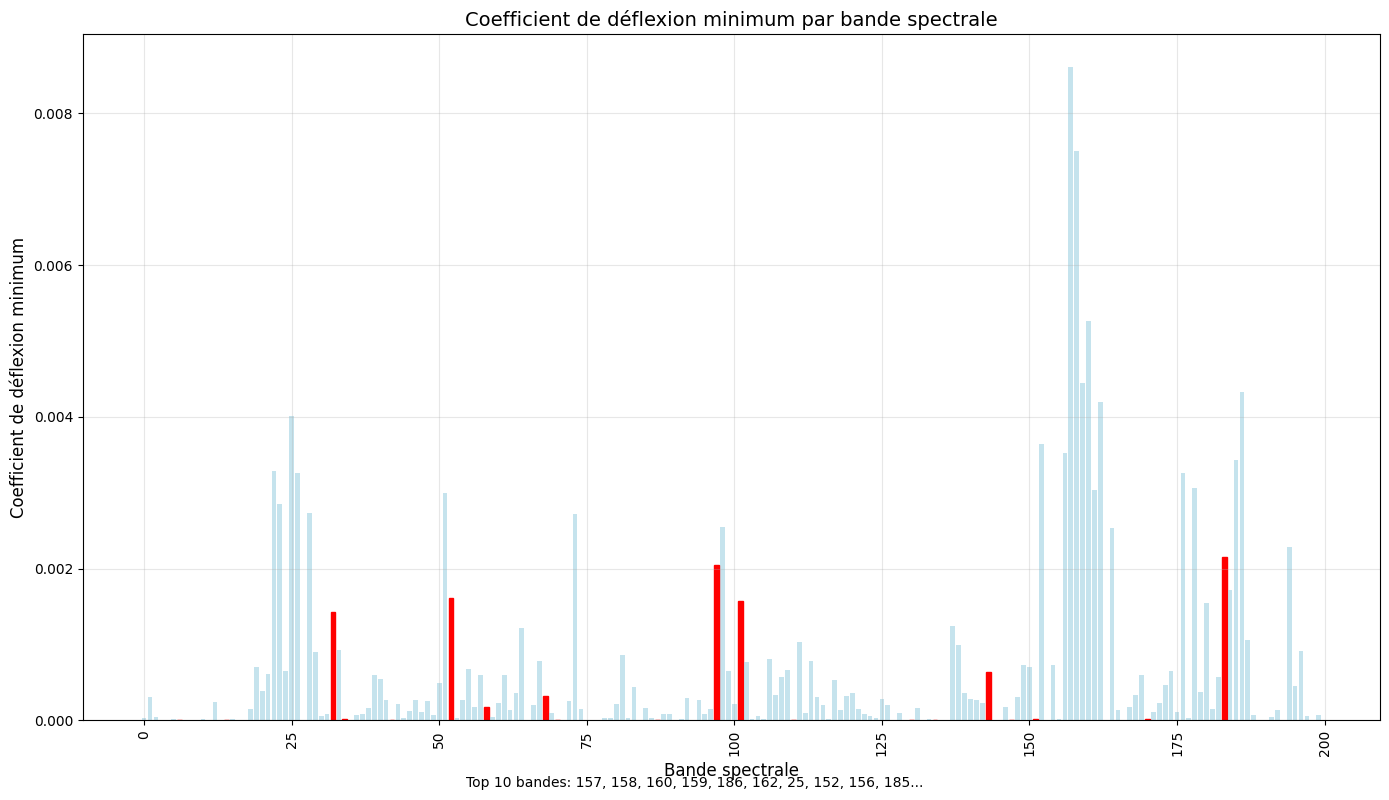

Graphique sauvegardé dans 'coefficients_deflexion_par_bande.png'

####################################################################################################
#                                      FIN DE L'ANALYSE                                      #
####################################################################################################



In [24]:
def main():
    print("\n" + "#"*100)
    print("#" + " "*38 + "ANALYSE HYPERSPECTRALE" + " "*38 + "#")
    print("#" + " "*26 + "SELECTION DE BANDES PAR COEFFICIENT DE DÉFLEXION" + " "*26 + "#")
    print("#"*100 + "\n")
    
    # Étape 1: Charger les données
    donnees_hyperspectrales, verite_terrain = charger_donnees(dataset_path)
    
    # Étape 2: Préparer les données
    pixels, classes, classes_uniques, class_names = preparer_donnees(donnees_hyperspectrales, verite_terrain)
    
    # Étape 3: Calculer les coefficients de déflexion
    resultats_dc = calculer_coefficient_deflexion(pixels, classes, classes_uniques, class_names)
    
    # Étape 4: Analyser les coefficients de déflexion
    min_dc_par_bande, top_bandes = analyser_coefficients_deflexion(resultats_dc, top_n=20)
    
    # Étape 5: Afficher et sauvegarder les résultats
    afficher_resultats(resultats_dc, min_dc_par_bande, top_bandes, top_n=20)
    
    # Étape 6: Visualiser les résultats
    visualiser_resultats(min_dc_par_bande, top_bandes)
    
    print("\n" + "#"*100)
    print("#" + " "*38 + "FIN DE L'ANALYSE" + " "*38 + "#")
    print("#"*100 + "\n")

if __name__ == "__main__":
    main()

### Étape 8: Classification multiclasse avec MLP en utilisant différents ensembles de bandes discriminantes

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import os
from scipy.io import loadmat
from tqdm import tqdm

# Définir explicitement les noms des classes
class_names_custom = [
    'Background',
    'Alfalfa',
    'Corn-notill',
    'Corn-mintill',
    'Corn',
    'Grass-pasture',
    'Grass-trees',
    'Grass-pasture-mowed',
    'Hay-windrowed',
    'Oats',
    'Soybean-notill',
    'Soybean-mintill',
    'Soybean-clean',
    'Wheat',
    'Woods',
    'Buildings-Grass-Trees-Drives',
    'Stone-Steel-Towers'
]

# Définir le chemin du dataset
dataset_path = "/kaggle/input/dataset-deflection-coefficient"  # Chemin corrigé

# Charger les données hyperspectrales et vérités terrain
def charger_donnees_pour_mlp():
    print("Chargement des données pour le MLP...")
    # Charger l'image hyperspectrale
    chemin_image = os.path.join(dataset_path, "Indian_pines_corrected.mat")
    donnees_mat = loadmat(chemin_image)
    donnees_hyperspectrales = donnees_mat['indian_pines_corrected']
    
    # Charger la vérité terrain
    chemin_gt = os.path.join(dataset_path, "Indian_pines_gt.mat")
    gt_mat = loadmat(chemin_gt)
    verite_terrain = gt_mat['indian_pines_gt']
    
    # Réorganiser les données
    height, width, n_bands = donnees_hyperspectrales.shape
    pixels = donnees_hyperspectrales.reshape(height * width, n_bands)
    classes = verite_terrain.reshape(height * width)
    
    print(f"Dimensions des données: pixels {pixels.shape}, classes {classes.shape}")
    return pixels, classes

# 1. Fonction pour préparer les données selon les bandes sélectionnées
def preparer_donnees_mlp(pixels, classes, bandes_selectionnees):
    """
    Prépare les données pour l'entraînement avec les bandes sélectionnées.
    Inclut la classe de fond (background).
    
    Args:
        pixels: Données spectrales (n_pixels x n_bandes)
        classes: Étiquettes de classe pour chaque pixel
        bandes_selectionnees: Liste des indices des bandes à utiliser
    
    Returns:
        X_train, X_test, y_train, y_test: Ensembles d'entraînement et de test
    """
    # Utiliser tous les pixels, y compris la classe de fond (0)
    X = pixels   # Toutes les bandes
    y = classes  # Étiquettes (garder les indices originaux y compris 0)
    
    # Nombre de classes (incluant le fond)
    n_classes = len(np.unique(y))
    print(f"Nombre de classes (avec background): {n_classes}")
    
    # Sélectionner uniquement les bandes choisies
    X_selected = X[:, bandes_selectionnees]
    print(f"Dimensions des données: {X_selected.shape}")
    
    # Standardisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Conversion des étiquettes en format one-hot
    y_onehot = to_categorical(y)
    
    # Diviser en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_onehot, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Ensemble d'entraînement: {X_train.shape}, {y_train.shape}")
    print(f"Ensemble de test: {X_test.shape}, {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, n_classes

# 2. Définition du modèle MLP multiclasse avec BatchNorm avant activation
def creer_modele_mlp_multiclasse(input_dim, n_classes):
    """
    Crée un modèle MLP pour la classification multiclasse avec architecture 512-64-64-32
    et BatchNorm avant activation.
    """
    inputs = Input(shape=(input_dim,))
    
    # Première couche cachée
    x = Dense(512)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Deuxième couche cachée
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    # Troisième couche cachée
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Quatrième couche cachée
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Couche de sortie avec softmax pour la classification multiclasse
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 3. Fonction pour entraîner et évaluer un modèle
def entrainer_evaluer_modele(X_train, X_test, y_train, y_test, n_classes, 
                           bandes_selectionnees, nom_modele):
    """
    Entraîne et évalue un modèle MLP avec les données fournies.
    
    Args:
        X_train, X_test, y_train, y_test: Ensembles d'entraînement et de test
        n_classes: Nombre de classes
        bandes_selectionnees: Liste des indices des bandes utilisées
        nom_modele: Nom pour sauvegarder le modèle et les résultats
    
    Returns:
        model: Le modèle entraîné
        history: L'historique d'entraînement
        metrics: Dictionnaire des métriques d'évaluation
    """
    # Créer un dossier pour les résultats de ce modèle
    os.makedirs(f"resultats_{nom_modele}", exist_ok=True)
    
    print(f"\nCréation et entraînement du modèle {nom_modele}...")
    start_time = time.time()
    
    # Créer le modèle
    model = creer_modele_mlp_multiclasse(input_dim=len(bandes_selectionnees), n_classes=n_classes)
    model.summary()
    
    # Définir l'early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Entraîner le modèle
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    train_time = time.time() - start_time
    print(f"\nTemps d'entraînement: {train_time:.2f} secondes")
    
    # Évaluation du modèle
    print("\nÉvaluation du modèle sur l'ensemble de test...")
    start_time = time.time()
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    predict_time = time.time() - start_time
    
    print(f"Précision (accuracy): {accuracy:.4f}")
    print(f"Temps de prédiction: {predict_time:.2f} secondes")
    
    # Générer les prédictions
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Utiliser tous les noms de classes, y compris le background
    class_labels = class_names_custom[:n_classes]
    
    # Rapport de classification détaillé
    report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
    print("\nRapport de classification:")
    print(report)
    
    # Sauvegarder le rapport dans un fichier
    with open(f"resultats_{nom_modele}/rapport_classification_{nom_modele}.txt", "w") as f:
        f.write(f"Précision (accuracy): {accuracy:.4f}\n")
        f.write(f"Temps d'entraînement: {train_time:.2f} secondes\n")
        f.write(f"Temps de prédiction: {predict_time:.2f} secondes\n\n")
        f.write(report)
    
    # Visualisations
    # Courbes d'apprentissage
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"resultats_{nom_modele}/learning_curves_{nom_modele}.png")
    plt.close()
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 14))
    
    # Utiliser des étiquettes sécurisées pour les axes
    x_labels = [label[:10] for label in class_labels]
    y_labels = [label[:10] for label in class_labels]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=x_labels, 
                yticklabels=y_labels)
    plt.title(f'Matrice de confusion - {nom_modele}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.tight_layout()
    plt.savefig(f"resultats_{nom_modele}/confusion_matrix_{nom_modele}.png")
    plt.close()
    
    # Précision par classe
    # Récupérer le rapport sous forme de dictionnaire
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Préparer les données pour la visualisation
    precision_by_class = []
    for i, classe in enumerate(class_labels):
        if classe in report_dict:
            classe_dict = report_dict[classe]
            precision_by_class.append({
                'Classe': classe,
                'Précision': classe_dict['precision'],
                'Rappel': classe_dict['recall'],
                'F1-score': classe_dict['f1-score'],
                'Support': classe_dict['support']
            })
    
    # Créer le DataFrame et trier
    precision_df = pd.DataFrame(precision_by_class)
    if not precision_df.empty:
        precision_df = precision_df.sort_values('F1-score', ascending=False)
        
        # Visualisation
        plt.figure(figsize=(14, 8))
        sns.barplot(x='Classe', y='F1-score', data=precision_df)
        plt.title(f'F1-score par classe - {nom_modele}')
        plt.xlabel('Classe')
        plt.ylabel('F1-score')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f"resultats_{nom_modele}/f1score_by_class_{nom_modele}.png")
        plt.close()
        
        # Sauvegarder les F1-scores par classe
        precision_df.to_csv(f"resultats_{nom_modele}/f1scores_{nom_modele}.csv", index=False)
    else:
        print("Impossible de créer la visualisation du F1-score par classe - données insuffisantes")
    
    # Sauvegarde du modèle
    model.save(f"resultats_{nom_modele}/model_{nom_modele}.h5")
    print(f"\nModèle sauvegardé sous 'resultats_{nom_modele}/model_{nom_modele}.h5'")
    
    # Enregistrer les informations sur les bandes sélectionnées
    pd.DataFrame({
        'Bande': bandes_selectionnees,
        'CoefficientDeflexion': [float(min_dc_par_bande[min_dc_par_bande['Bande'] == b]['CoefficientDeflexion'].values[0]) 
                         for b in bandes_selectionnees]
    }).to_csv(f"resultats_{nom_modele}/bandes_selectionnees_{nom_modele}.csv", index=False)
    
    # Rassembler les métriques pour la comparaison finale
    metrics = {
        'accuracy': accuracy,
        'train_time': train_time,
        'predict_time': predict_time,
        'n_bands': len(bandes_selectionnees)
    }
    
    return model, history, metrics

# 4. Fonction principale pour entraîner tous les modèles
def entrainer_tous_modeles():
    """
    Fonction principale pour entraîner et évaluer tous les modèles.
    """
    # Créer un dossier de sortie pour les résultats globaux
    os.makedirs("resultats_comparaison", exist_ok=True)
    
    # Liste pour stocker les métriques de tous les modèles
    all_metrics = []
    
    # 1. Modèle avec Top 5 bandes
    print("\n========== MODÈLE TOP 5 BANDES ==========")
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, top5_bandes)
    _, _, metrics_top5 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, top5_bandes, "top5_deflection"
    )
    metrics_top5['model'] = 'Top 5 bandes'
    all_metrics.append(metrics_top5)
    
    # 2. Modèle avec Top 10 bandes
    print("\n========== MODÈLE TOP 10 BANDES ==========")
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, top10_bandes)
    _, _, metrics_top10 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, top10_bandes, "top10_deflection"
    )
    metrics_top10['model'] = 'Top 10 bandes'
    all_metrics.append(metrics_top10)
    
    # 3. Modèle avec Top 15 bandes
    print("\n========== MODÈLE TOP 15 BANDES ==========")
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, top15_bandes)
    _, _, metrics_top15 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, top15_bandes, "top15_deflection"
    )
    metrics_top15['model'] = 'Top 15 bandes'
    all_metrics.append(metrics_top15)
    
    # 4. Modèle avec Top 20 bandes
    print("\n========== MODÈLE TOP 20 BANDES ==========")
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, top20_bandes)
    _, _, metrics_top20 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, top20_bandes, "top20_deflection"
    )
    metrics_top20['model'] = 'Top 20 bandes'
    all_metrics.append(metrics_top20)
    
    # Créer un tableau de comparaison
    comparison_df = pd.DataFrame(all_metrics)
    comparison_df = comparison_df[['model', 'n_bands', 'accuracy', 'train_time', 'predict_time']]
    comparison_df.columns = ['Modèle', 'Nombre de bandes', 'Précision', 'Temps d\'entraînement (s)', 'Temps de prédiction (s)']
    
    # Sauvegarder le tableau de comparaison
    comparison_df.to_csv("resultats_comparaison/comparaison_modeles_deflection.csv", index=False)
    print("\nTableau de comparaison sauvegardé dans 'resultats_comparaison/comparaison_modeles_deflection.csv'")
    
    # Visualiser la comparaison des précisions
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Modèle', y='Précision', data=comparison_df)
    plt.title('Comparaison de la précision des modèles')
    plt.xlabel('Modèle')
    plt.ylabel('Précision')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("resultats_comparaison/comparaison_precision_deflection.png")
    plt.close()
    
    # Visualiser la comparaison des temps d'entraînement
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Modèle', y='Temps d\'entraînement (s)', data=comparison_df)
    plt.title('Comparaison des temps d\'entraînement')
    plt.xlabel('Modèle')
    plt.ylabel('Temps d\'entraînement (s)')
    plt.tight_layout()
    plt.savefig("resultats_comparaison/comparaison_temps_entrainement_deflection.png")
    plt.close()
    
    print("\nAnalyse comparative terminée!")
    print("\nRécapitulatif des précisions:")
    for metric in all_metrics:
        print(f"{metric['model']}: {metric['accuracy']:.4f}")
    
    return comparison_df

# Charger les données
pixels, classes = charger_donnees_pour_mlp()

# Charger les résultats de coefficient de déflexion
print("Chargement des résultats de coefficient de déflexion...")
min_dc_par_bande = pd.read_csv('coefficients_deflexion_par_bande_tri.csv')

# Sélection des meilleures bandes selon les différentes configurations
print("Sélection des meilleures bandes selon différentes configurations...")
top5_bandes = min_dc_par_bande.head(5)['Bande'].values
top10_bandes = min_dc_par_bande.head(10)['Bande'].values
top15_bandes = min_dc_par_bande.head(15)['Bande'].values
top20_bandes = min_dc_par_bande.head(20)['Bande'].values

print(f"Top 5 bandes: {top5_bandes}")
print(f"Top 10 bandes: {top10_bandes}")
print(f"Top 15 bandes: {top15_bandes}")
print(f"Top 20 bandes: {top20_bandes}")

# Exécuter l'entraînement des modèles
if __name__ == "__main__":
    comparison_results = entrainer_tous_modeles()

Chargement des données pour le MLP...
Dimensions des données: pixels (21025, 200), classes (21025,)
Chargement des résultats de coefficient de déflexion...
Sélection des meilleures bandes selon différentes configurations...
Top 5 bandes: [157 158 160 159 186]
Top 10 bandes: [157 158 160 159 186 162  25 152 156 185]
Top 15 bandes: [157 158 160 159 186 162  25 152 156 185  22 176  26 178 161]
Top 20 bandes: [157 158 160 159 186 162  25 152 156 185  22 176  26 178 161  51  23  28
  73  98]

========== MODÈLE TOP 5 BANDES ==========
Nombre de classes (avec background): 17
Dimensions des données: (21025, 5)
Ensemble d'entraînement: (14717, 5), (14717, 17)
Ensemble de test: (6308, 5), (6308, 17)

Création et entraînement du modèle top5_deflection...


I0000 00:00:1746793612.023464      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746793612.024236      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,393 (177.32 KB)

 Trainable params: 44,049 (172.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100


I0000 00:00:1746793617.254940      97 service.cc:148] XLA service 0x7f2064029c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746793617.255619      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746793617.255635      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746793617.685744      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 96/368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1873 - loss: 2.6856

I0000 00:00:1746793619.714723      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3817 - loss: 2.0820 - val_accuracy: 0.5459 - val_loss: 1.3880
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5649 - loss: 1.3385 - val_accuracy: 0.5707 - val_loss: 1.2730
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5667 - loss: 1.3093 - val_accuracy: 0.5771 - val_loss: 1.2485
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5569 - loss: 1.3164 - val_accuracy: 0.5730 - val_loss: 1.2525
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5588 - loss: 1.2956 - val_accuracy: 0.5771 - val_loss: 1.2432
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5516 - loss: 1.3366 - val_accuracy: 0.5673 - val_loss: 1.2491
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5626 - loss: 1.2808 - val_accuracy: 0.5707 - val_loss: 1.2354
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5597 - loss: 1.2905 - val_accuracy: 0.56

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,953 (187.32 KB)

 Trainable params: 46,609 (182.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4875 - loss: 1.8012 - val_accuracy: 0.5720 - val_loss: 1.3322
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5714 - loss: 1.2719 - val_accuracy: 0.5819 - val_loss: 1.1757
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5888 - loss: 1.1927 - val_accuracy: 0.5764 - val_loss: 1.1679
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5846 - loss: 1.1990 - val_accuracy: 0.5883 - val_loss: 1.1560
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5950 - loss: 1.1749 - val_accuracy: 0.6097 - val_loss: 1.1091
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5860 - loss: 1.1665 - val_accuracy: 0.5910 - val_loss: 1.1679
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5902 - loss: 1.1554 - val_accuracy: 0.6097 - val_loss: 1.0940
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5916 - loss: 1.1499 - val_accu

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,513 (197.32 KB)

 Trainable params: 49,169 (192.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4862 - loss: 1.8599 - val_accuracy: 0.5744 - val_loss: 1.2735
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5605 - loss: 1.2900 - val_accuracy: 0.6084 - val_loss: 1.1587
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5841 - loss: 1.2024 - val_accuracy: 0.5951 - val_loss: 1.1216
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5963 - loss: 1.1622 - val_accuracy: 0.5985 - val_loss: 1.1124
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5902 - loss: 1.1572 - val_accuracy: 0.6056 - val_loss: 1.0916
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5864 - loss: 1.1588 - val_accuracy: 0.6124 - val_loss: 1.0727
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5949 - loss: 1.1362 - val_accuracy: 0.6053 - val_loss: 1.0751
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5916 - loss: 1.1306 - val_accu

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,073 (207.32 KB)

 Trainable params: 51,729 (202.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4458 - loss: 2.0256 - val_accuracy: 0.6182 - val_loss: 1.1210
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5948 - loss: 1.1619 - val_accuracy: 0.6253 - val_loss: 1.0084
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6121 - loss: 1.0733 - val_accuracy: 0.6471 - val_loss: 0.9501
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6167 - loss: 1.0573 - val_accuracy: 0.6559 - val_loss: 0.9464
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6354 - loss: 0.9920 - val_accuracy: 0.6450 - val_loss: 0.9386
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6350 - loss: 0.9813 - val_accuracy: 0.6644 - val_loss: 0.8891
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6495 - loss: 0.9675 - val_accuracy: 0.6695 - val_loss: 0.8818
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6483 - loss: 0.9458 - val_accu

### Étape 9: Classification multiclasse avec MLP en utilisant des bandes discriminantes par segments égaux

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import os
from scipy.io import loadmat
from tqdm import tqdm

# Définir explicitement les noms des classes
class_names_custom = [
    'Background',
    'Alfalfa',
    'Corn-notill',
    'Corn-mintill',
    'Corn',
    'Grass-pasture',
    'Grass-trees',
    'Grass-pasture-mowed',
    'Hay-windrowed',
    'Oats',
    'Soybean-notill',
    'Soybean-mintill',
    'Soybean-clean',
    'Wheat',
    'Woods',
    'Buildings-Grass-Trees-Drives',
    'Stone-Steel-Towers'
]

# Définir le chemin du dataset
dataset_path = "/kaggle/input/dataset-deflection-coefficient"  # Chemin vers le dossier du dataset

# Charger les données hyperspectrales et vérités terrain
def charger_donnees_pour_mlp():
    print("Chargement des données pour le MLP...")
    # Charger l'image hyperspectrale
    chemin_image = os.path.join(dataset_path, "Indian_pines_corrected.mat")
    donnees_mat = loadmat(chemin_image)
    donnees_hyperspectrales = donnees_mat['indian_pines_corrected']
    
    # Charger la vérité terrain
    chemin_gt = os.path.join(dataset_path, "Indian_pines_gt.mat")
    gt_mat = loadmat(chemin_gt)
    verite_terrain = gt_mat['indian_pines_gt']
    
    # Réorganiser les données
    height, width, n_bands = donnees_hyperspectrales.shape
    pixels = donnees_hyperspectrales.reshape(height * width, n_bands)
    classes = verite_terrain.reshape(height * width)
    
    print(f"Dimensions des données: pixels {pixels.shape}, classes {classes.shape}")
    return pixels, classes

# Fonction pour sélectionner les meilleures bandes par segments égaux selon le coefficient de déflexion
def selectionner_meilleures_bandes_par_segment(min_dc_par_bande, nb_segments):
    """
    Sélectionne la meilleure bande (selon le coefficient de déflexion) dans chaque segment spectral.
    
    Args:
        min_dc_par_bande: DataFrame contenant les coefficients de déflexion pour chaque bande
        nb_segments: Nombre de segments spectraux à considérer
    
    Returns:
        Liste des indices des bandes sélectionnées
    """
    # Nombre total de bandes
    nb_bandes_total = min_dc_par_bande['Bande'].max() + 1
    
    # Taille approximative de chaque segment
    taille_segment = nb_bandes_total // nb_segments
    
    bandes_selectionnees = []
    segments_info = []
    
    print(f"\nDivision du spectre en {nb_segments} segments de {taille_segment} bandes chacun")
    
    # Pour chaque segment spectral
    for i in range(nb_segments):
        # Calculer les limites du segment
        debut = i * taille_segment
        fin = min((i + 1) * taille_segment - 1, nb_bandes_total - 1)
        
        print(f"Segment {i+1}: bandes {debut} à {fin}")
        
        # Sélectionner les bandes dans ce segment
        segment_df = min_dc_par_bande[(min_dc_par_bande['Bande'] >= debut) & (min_dc_par_bande['Bande'] <= fin)]
        
        # Trier le segment par coefficient de déflexion décroissant
        segment_df = segment_df.sort_values('CoefficientDeflexion', ascending=False)
        
        # Trouver la bande avec le meilleur coefficient de déflexion dans ce segment
        if not segment_df.empty:
            meilleure_bande = segment_df.iloc[0]['Bande']
            meilleur_coefficient = segment_df.iloc[0]['CoefficientDeflexion']
            bandes_selectionnees.append(int(meilleure_bande))
            
            segments_info.append({
                'Segment': i+1,
                'Debut': debut,
                'Fin': fin,
                'MeilleureBande': int(meilleure_bande),
                'Coefficient': float(meilleur_coefficient)
            })
            
            print(f"  → Meilleure bande: {int(meilleure_bande)} (Coefficient: {float(meilleur_coefficient):.4f})")
        else:
            print(f"  → Aucune bande trouvée dans ce segment")
    
    # Sauvegarder les informations sur les segments
    pd.DataFrame(segments_info).to_csv(f'segments_info_{nb_segments}.csv', index=False)
    print(f"Informations sur les segments sauvegardées dans 'segments_info_{nb_segments}.csv'")
    
    return bandes_selectionnees

# 1. Fonction pour préparer les données selon les bandes sélectionnées
def preparer_donnees_mlp(pixels, classes, bandes_selectionnees):
    """
    Prépare les données pour l'entraînement avec les bandes sélectionnées.
    Inclut la classe de fond (background).
    
    Args:
        pixels: Données spectrales (n_pixels x n_bandes)
        classes: Étiquettes de classe pour chaque pixel
        bandes_selectionnees: Liste des indices des bandes à utiliser
    
    Returns:
        X_train, X_test, y_train, y_test: Ensembles d'entraînement et de test
    """
    # Utiliser tous les pixels, y compris la classe de fond (0)
    X = pixels   # Toutes les bandes
    y = classes  # Étiquettes (garder les indices originaux y compris 0)
    
    # Nombre de classes (incluant le fond)
    n_classes = len(np.unique(y))
    print(f"Nombre de classes (avec background): {n_classes}")
    
    # Sélectionner uniquement les bandes choisies
    X_selected = X[:, bandes_selectionnees]
    print(f"Dimensions des données: {X_selected.shape}")
    
    # Standardisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Conversion des étiquettes en format one-hot
    y_onehot = to_categorical(y)
    
    # Diviser en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_onehot, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Ensemble d'entraînement: {X_train.shape}, {y_train.shape}")
    print(f"Ensemble de test: {X_test.shape}, {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, n_classes

# 2. Définition du modèle MLP multiclasse avec BatchNorm avant activation
def creer_modele_mlp_multiclasse(input_dim, n_classes):
    """
    Crée un modèle MLP pour la classification multiclasse avec architecture 512-64-64-32
    et BatchNorm avant activation.
    """
    inputs = Input(shape=(input_dim,))
    
    # Première couche cachée
    x = Dense(512)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Deuxième couche cachée
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    # Troisième couche cachée
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Quatrième couche cachée
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Couche de sortie avec softmax pour la classification multiclasse
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 3. Fonction pour entraîner et évaluer un modèle
def entrainer_evaluer_modele(X_train, X_test, y_train, y_test, n_classes, 
                           bandes_selectionnees, nom_modele):
    """
    Entraîne et évalue un modèle MLP avec les données fournies.
    
    Args:
        X_train, X_test, y_train, y_test: Ensembles d'entraînement et de test
        n_classes: Nombre de classes
        bandes_selectionnees: Liste des indices des bandes utilisées
        nom_modele: Nom pour sauvegarder le modèle et les résultats
    
    Returns:
        model: Le modèle entraîné
        history: L'historique d'entraînement
        metrics: Dictionnaire des métriques d'évaluation
    """
    # Créer un dossier pour les résultats de ce modèle
    os.makedirs(f"resultats_{nom_modele}", exist_ok=True)
    
    print(f"\nCréation et entraînement du modèle {nom_modele}...")
    start_time = time.time()
    
    # Créer le modèle
    model = creer_modele_mlp_multiclasse(input_dim=len(bandes_selectionnees), n_classes=n_classes)
    model.summary()
    
    # Définir l'early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Entraîner le modèle
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    train_time = time.time() - start_time
    print(f"\nTemps d'entraînement: {train_time:.2f} secondes")
    
    # Évaluation du modèle
    print("\nÉvaluation du modèle sur l'ensemble de test...")
    start_time = time.time()
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    predict_time = time.time() - start_time
    
    print(f"Précision (accuracy): {accuracy:.4f}")
    print(f"Temps de prédiction: {predict_time:.2f} secondes")
    
    # Générer les prédictions
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Utiliser tous les noms de classes, y compris le background
    class_labels = class_names_custom[:n_classes]
    
    # Rapport de classification détaillé
    report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
    print("\nRapport de classification:")
    print(report)
    
    # Sauvegarder le rapport dans un fichier
    with open(f"resultats_{nom_modele}/rapport_classification_{nom_modele}.txt", "w") as f:
        f.write(f"Précision (accuracy): {accuracy:.4f}\n")
        f.write(f"Temps d'entraînement: {train_time:.2f} secondes\n")
        f.write(f"Temps de prédiction: {predict_time:.2f} secondes\n\n")
        f.write(report)
    
    # Visualisations
    # Courbes d'apprentissage
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"resultats_{nom_modele}/learning_curves_{nom_modele}.png")
    plt.close()
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 14))
    
    # Utiliser des étiquettes sécurisées pour les axes
    x_labels = [label[:10] for label in class_labels]
    y_labels = [label[:10] for label in class_labels]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=x_labels, 
                yticklabels=y_labels)
    plt.title(f'Matrice de confusion - {nom_modele}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.tight_layout()
    plt.savefig(f"resultats_{nom_modele}/confusion_matrix_{nom_modele}.png")
    plt.close()
    
    # Précision par classe
    # Récupérer le rapport sous forme de dictionnaire
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Préparer les données pour la visualisation
    precision_by_class = []
    for i, classe in enumerate(class_labels):
        if classe in report_dict:
            classe_dict = report_dict[classe]
            precision_by_class.append({
                'Classe': classe,
                'Précision': classe_dict['precision'],
                'Rappel': classe_dict['recall'],
                'F1-score': classe_dict['f1-score'],
                'Support': classe_dict['support']
            })
    
    # Créer le DataFrame et trier
    precision_df = pd.DataFrame(precision_by_class)
    if not precision_df.empty:
        precision_df = precision_df.sort_values('F1-score', ascending=False)
        
        # Visualisation
        plt.figure(figsize=(14, 8))
        sns.barplot(x='Classe', y='F1-score', data=precision_df)
        plt.title(f'F1-score par classe - {nom_modele}')
        plt.xlabel('Classe')
        plt.ylabel('F1-score')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f"resultats_{nom_modele}/f1score_by_class_{nom_modele}.png")
        plt.close()
        
        # Sauvegarder les F1-scores par classe
        precision_df.to_csv(f"resultats_{nom_modele}/f1scores_{nom_modele}.csv", index=False)
    else:
        print("Impossible de créer la visualisation du F1-score par classe - données insuffisantes")
    
    # Sauvegarde du modèle
    model.save(f"resultats_{nom_modele}/model_{nom_modele}.h5")
    print(f"\nModèle sauvegardé sous 'resultats_{nom_modele}/model_{nom_modele}.h5'")
    
    # Enregistrer les informations sur les bandes sélectionnées
    pd.DataFrame({
        'Bande': bandes_selectionnees,
        'Segment': range(1, len(bandes_selectionnees) + 1),
        'CoefficientDeflexion': [float(min_dc_par_bande[min_dc_par_bande['Bande'] == b]['CoefficientDeflexion'].values[0]) 
                         for b in bandes_selectionnees]
    }).to_csv(f"resultats_{nom_modele}/bandes_selectionnees_{nom_modele}.csv", index=False)
    
    # Rassembler les métriques pour la comparaison finale
    metrics = {
        'accuracy': accuracy,
        'train_time': train_time,
        'predict_time': predict_time,
        'n_bands': len(bandes_selectionnees)
    }
    
    return model, history, metrics

# 4. Fonction principale pour entraîner tous les modèles
def entrainer_tous_modeles_segments_deflection():
    """
    Fonction principale pour entraîner et évaluer tous les modèles avec des bandes
    sélectionnées par segments selon le coefficient de déflexion.
    """
    # Créer un dossier de sortie pour les résultats globaux
    os.makedirs("resultats_comparaison_segments_deflection", exist_ok=True)
    
    # Liste pour stocker les métriques de tous les modèles
    all_metrics = []
    
    # 1. Modèle avec 5 segments égaux (1 bande par segment)
    print("\n" + "="*80)
    print("MODÈLE AVEC 5 SEGMENTS - COEFFICIENT DE DÉFLEXION")
    print("="*80)
    seg5_bandes = selectionner_meilleures_bandes_par_segment(min_dc_par_bande, 5)
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, seg5_bandes)
    _, _, metrics_seg5 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, seg5_bandes, "seg5_deflection"
    )
    metrics_seg5['model'] = '5 segments (5 bandes)'
    all_metrics.append(metrics_seg5)
    
    # 2. Modèle avec 10 segments égaux (1 bande par segment)
    print("\n" + "="*80)
    print("MODÈLE AVEC 10 SEGMENTS - COEFFICIENT DE DÉFLEXION")
    print("="*80)
    seg10_bandes = selectionner_meilleures_bandes_par_segment(min_dc_par_bande, 10)
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, seg10_bandes)
    _, _, metrics_seg10 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, seg10_bandes, "seg10_deflection"
    )
    metrics_seg10['model'] = '10 segments (10 bandes)'
    all_metrics.append(metrics_seg10)
    
    # 3. Modèle avec 15 segments égaux (1 bande par segment)
    print("\n" + "="*80)
    print("MODÈLE AVEC 15 SEGMENTS - COEFFICIENT DE DÉFLEXION")
    print("="*80)
    seg15_bandes = selectionner_meilleures_bandes_par_segment(min_dc_par_bande, 15)
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, seg15_bandes)
    _, _, metrics_seg15 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, seg15_bandes, "seg15_deflection"
    )
    metrics_seg15['model'] = '15 segments (15 bandes)'
    all_metrics.append(metrics_seg15)
    
    # 4. Modèle avec 20 segments égaux (1 bande par segment)
    print("\n" + "="*80)
    print("MODÈLE AVEC 20 SEGMENTS - COEFFICIENT DE DÉFLEXION")
    print("="*80)
    seg20_bandes = selectionner_meilleures_bandes_par_segment(min_dc_par_bande, 20)
    X_train, X_test, y_train, y_test, n_classes = preparer_donnees_mlp(pixels, classes, seg20_bandes)
    _, _, metrics_seg20 = entrainer_evaluer_modele(
        X_train, X_test, y_train, y_test, n_classes, seg20_bandes, "seg20_deflection"
    )
    metrics_seg20['model'] = '20 segments (20 bandes)'
    all_metrics.append(metrics_seg20)
    
    # Créer un tableau de comparaison
    comparison_df = pd.DataFrame(all_metrics)
    comparison_df = comparison_df[['model', 'n_bands', 'accuracy', 'train_time', 'predict_time']]
    comparison_df.columns = ['Modèle', 'Nombre de bandes', 'Précision', 'Temps d\'entraînement (s)', 'Temps de prédiction (s)']
    
    # Sauvegarder le tableau de comparaison
    comparison_df.to_csv("resultats_comparaison_segments_deflection/comparaison_modeles_segments.csv", index=False)
    print("\nTableau de comparaison sauvegardé dans 'resultats_comparaison_segments_deflection/comparaison_modeles_segments.csv'")
    
    # Visualiser la comparaison des précisions
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Modèle', y='Précision', data=comparison_df)
    plt.title('Comparaison de la précision des modèles (Segments - Coefficient de Déflexion)')
    plt.xlabel('Modèle')
    plt.ylabel('Précision')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("resultats_comparaison_segments_deflection/comparaison_precision_segments.png")
    plt.close()
    
    # Visualiser la comparaison des temps d'entraînement
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Modèle', y='Temps d\'entraînement (s)', data=comparison_df)
    plt.title('Comparaison des temps d\'entraînement (Segments - Coefficient de Déflexion)')
    plt.xlabel('Modèle')
    plt.ylabel('Temps d\'entraînement (s)')
    plt.tight_layout()
    plt.savefig("resultats_comparaison_segments_deflection/comparaison_temps_entrainement_segments.png")
    plt.close()
    
    # Visualiser la distribution des bandes sélectionnées
    plt.figure(figsize=(15, 8))
    
    # Créer une matrice pour représenter toutes les bandes
    markers = ['o', 's', 'D', '^']
    colors = ['blue', 'green', 'red', 'purple']
    labels = ['5 segments', '10 segments', '15 segments', '20 segments']
    
    # Tracer la distribution des bandes pour chaque configuration
    for i, bandes in enumerate([seg5_bandes, seg10_bandes, seg15_bandes, seg20_bandes]):
        plt.scatter(bandes, np.ones(len(bandes))*i+1, marker=markers[i], 
                   color=colors[i], s=100, label=labels[i])
    
    # Ajouter des lignes verticales pour montrer les segments spectraux
    for i in range(1, 20):
        plt.axvline(x=i*10, color='gray', linestyle='--', alpha=0.3)
    
    plt.title('Distribution des bandes sélectionnées par l\'approche de segmentation avec coefficient de déflexion')
    plt.xlabel('Indice de bande')
    plt.yticks([1, 2, 3, 4], labels)
    plt.xlim(-5, 205)
    plt.grid(axis='x', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("resultats_comparaison_segments_deflection/distribution_bandes_segments.png")
    plt.close()
    
    print("\nAnalyse comparative terminée!")
    print("\nRécapitulatif des précisions:")
    for metric in all_metrics:
        print(f"{metric['model']}: {metric['accuracy']:.4f}")
    
    return comparison_df

# Charger les données
pixels, classes = charger_donnees_pour_mlp()

# Charger les résultats de coefficient de déflexion
print("Chargement des résultats de coefficient de déflexion...")
min_dc_par_bande = pd.read_csv('coefficients_deflexion_par_bande_tri.csv')

# Exécuter l'entraînement des modèles
if __name__ == "__main__":
    comparison_results = entrainer_tous_modeles_segments_deflection()

Chargement des données pour le MLP...
Dimensions des données: pixels (21025, 200), classes (21025,)
Chargement des résultats de coefficient de déflexion...

MODÈLE AVEC 5 SEGMENTS - COEFFICIENT DE DÉFLEXION

Division du spectre en 5 segments de 40 bandes chacun
Segment 1: bandes 0 à 39
  → Meilleure bande: 25 (Coefficient: 0.0040)
Segment 2: bandes 40 à 79
  → Meilleure bande: 51 (Coefficient: 0.0030)
Segment 3: bandes 80 à 119
  → Meilleure bande: 98 (Coefficient: 0.0025)
Segment 4: bandes 120 à 159
  → Meilleure bande: 157 (Coefficient: 0.0086)
Segment 5: bandes 160 à 199
  → Meilleure bande: 160 (Coefficient: 0.0053)
Informations sur les segments sauvegardées dans 'segments_info_5.csv'
Nombre de classes (avec background): 17
Dimensions des données: (21025, 5)
Ensemble d'entraînement: (14717, 5), (14717, 17)
Ensemble de test: (6308, 5), (6308, 17)

Création et entraînement du modèle seg5_deflection...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,393 (177.32 KB)

 Trainable params: 44,049 (172.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4551 - loss: 1.9552 - val_accuracy: 0.5625 - val_loss: 1.3092
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6092 - loss: 1.1420 - val_accuracy: 0.6464 - val_loss: 0.9977
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6243 - loss: 1.0495 - val_accuracy: 0.6444 - val_loss: 0.9520
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6135 - loss: 1.0442 - val_accuracy: 0.6488 - val_loss: 0.9171
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6405 - loss: 0.9940 - val_accuracy: 0.6321 - val_loss: 0.9790
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6373 - loss: 0.9733 - val_accuracy: 0.6596 - val_loss: 0.8955
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6400 - loss: 0.9727 - val_accuracy: 0.6736 - val_loss: 0.8772
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6374 - loss: 0.9613 - val_accu

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,953 (187.32 KB)

 Trainable params: 46,609 (182.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4637 - loss: 1.9437 - val_accuracy: 0.6084 - val_loss: 1.1952
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6081 - loss: 1.1349 - val_accuracy: 0.6413 - val_loss: 0.9711
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6274 - loss: 1.0472 - val_accuracy: 0.6556 - val_loss: 0.9254
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6427 - loss: 0.9890 - val_accuracy: 0.6719 - val_loss: 0.8941
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6483 - loss: 0.9656 - val_accuracy: 0.6712 - val_loss: 0.8800
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6473 - loss: 0.9541 - val_accuracy: 0.6712 - val_loss: 0.8644
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6508 - loss: 0.9449 - val_accuracy: 0.6685 - val_loss: 0.8645
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6495 - loss: 0.9434 - val_accu

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,513 (197.32 KB)

 Trainable params: 49,169 (192.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4923 - loss: 1.7641 - val_accuracy: 0.6209 - val_loss: 1.1268
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6037 - loss: 1.1426 - val_accuracy: 0.6416 - val_loss: 0.9740
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6202 - loss: 1.0709 - val_accuracy: 0.6630 - val_loss: 0.9409
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6248 - loss: 1.0311 - val_accuracy: 0.6681 - val_loss: 0.9150
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6466 - loss: 0.9678 - val_accuracy: 0.6573 - val_loss: 0.9086
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6440 - loss: 0.9612 - val_accuracy: 0.6899 - val_loss: 0.8423
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6511 - loss: 0.9289 - val_accuracy: 0.6776 - val_loss: 0.8685
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6598 - loss: 0.9218 - val_accu

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 512)                 │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 17)                  │             561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,073 (207.32 KB)

 Trainable params: 51,729 (202.07 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4187 - loss: 1.9861 - val_accuracy: 0.6118 - val_loss: 1.1105
Epoch 2/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6013 - loss: 1.1371 - val_accuracy: 0.6213 - val_loss: 0.9853
Epoch 3/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6367 - loss: 1.0137 - val_accuracy: 0.6844 - val_loss: 0.8730
Epoch 4/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6452 - loss: 0.9759 - val_accuracy: 0.6858 - val_loss: 0.8617
Epoch 5/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6483 - loss: 0.9655 - val_accuracy: 0.6576 - val_loss: 0.8929
Epoch 6/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6642 - loss: 0.9002 - val_accuracy: 0.6722 - val_loss: 0.8548
Epoch 7/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6649 - loss: 0.9024 - val_accuracy: 0.7069 - val_loss: 0.7700
Epoch 8/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6755 - loss: 0.8769 - val_accu